In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from fiona.crs import from_epsg
from geopandas.tools import sjoin, overlay
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def spatial_overlays(df1, df2, how='intersection', reproject=True):
    """Perform spatial overlay between two polygons.

    Currently only supports data GeoDataFrames with polygons.
    Implements several methods that are all effectively subsets of
    the union.

    Parameters
    ----------
    df1 : GeoDataFrame with MultiPolygon or Polygon geometry column
    df2 : GeoDataFrame with MultiPolygon or Polygon geometry column
    how : string
        Method of spatial overlay: 'intersection', 'union',
        'identity', 'symmetric_difference' or 'difference'.
    use_sindex : boolean, default True
        Use the spatial index to speed up operation if available.

    Returns
    -------
    df : GeoDataFrame
        GeoDataFrame with new set of polygons and attributes
        resulting from the overlay

    """
    from functools import reduce
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if df1.crs!=df2.crs and reproject:
        print('Data has different projections.')
        print('Converted data to projection of first GeoPandas DatFrame')
        df2.to_crs(crs=df1.crs, inplace=True)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['sidx'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('sidx')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        dfinter.drop(['idx1','idx2'], inplace=True, axis=1)
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                 [x.geometry]+list(df2.iloc[x.sidx].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'sidx', 'new_g'], axis=1, inplace=True)
        return df1
    elif how=='symmetric_difference':
        df1['idx1'] = df1.index.tolist()
        df2['idx2'] = df2.index.tolist()
        df1['idx2'] = np.nan
        df2['idx1'] = np.nan
        dfsym = df1.merge(df2, on=['idx1','idx2'], how='outer', suffixes=['_1','_2'])
        dfsym['geometry'] = dfsym.geometry_1
        dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry'] = dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry_2']
        dfsym.drop(['geometry_1', 'geometry_2'], axis=1, inplace=True)
        dfsym = gpd.GeoDataFrame(dfsym, columns=dfsym.columns, crs=df1.crs)
        spatial_index = dfsym.sindex
        dfsym['bbox'] = dfsym.geometry.apply(lambda x: x.bounds)
        dfsym['sidx'] = dfsym.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        dfsym['idx'] = dfsym.index.values
        dfsym.apply(lambda x: x.sidx.remove(x.idx), axis=1)
        dfsym['new_g'] = dfsym.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                         [x.geometry]+list(dfsym.iloc[x.sidx].geometry)) , axis=1)
        dfsym.geometry = dfsym.new_g
        dfsym = dfsym.loc[dfsym.geometry.is_empty==False].copy()
        dfsym.drop(['bbox', 'sidx', 'idx', 'idx1','idx2', 'new_g'], axis=1, inplace=True)
        return dfsym
    elif how=='union':
        dfinter = spatial_overlays(df1, df2, how='intersection')
        dfsym = spatial_overlays(df1, df2, how='symmetric_difference')
        dfunion = dfinter.append(dfsym)
        dfunion.reset_index(inplace=True, drop=True)
        return dfunion
    elif how=='identity':
        dfunion = spatial_overlays(df1, df2, how='union')
        cols1 = df1.columns.tolist()
        cols2 = df2.columns.tolist()
        cols1.remove('geometry')
        cols2.remove('geometry')
        cols2 = set(cols2).intersection(set(cols1))
        cols1 = list(set(cols1).difference(set(cols2)))
        cols2 = [col+'_1' for col in cols2]
        dfunion = dfunion[(dfunion[cols1+cols2].isnull()==False).values]
        return dfunion

## County District

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/12/DPW-Supervisorial-District.zip

In [ ]:
#!unzip DPW-Supervisorial-District.zip

In [3]:
dis = gpd.GeoDataFrame.from_file('sup_dist_2011.shp')

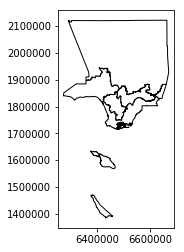

In [4]:
dis.plot(color='w', edgecolor='k')

## Council District

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/08/CnclDist_July2012.zip

In [ ]:
#!unzip CnclDist_July2012.zip

In [5]:
council = gpd.GeoDataFrame.from_file('CnclDist_July2012.shp')

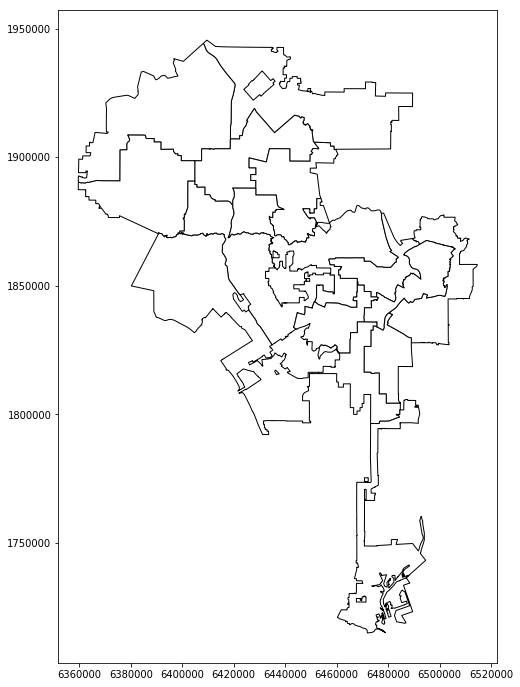

In [6]:
council.plot(color='w', edgecolor='k', figsize=(12,12))

In [7]:
dis_council = spatial_overlays(dis, council)

(6351824.8936360897,
 6522385.7341360925,
 1703504.2996880298,
 1957039.5930807188)

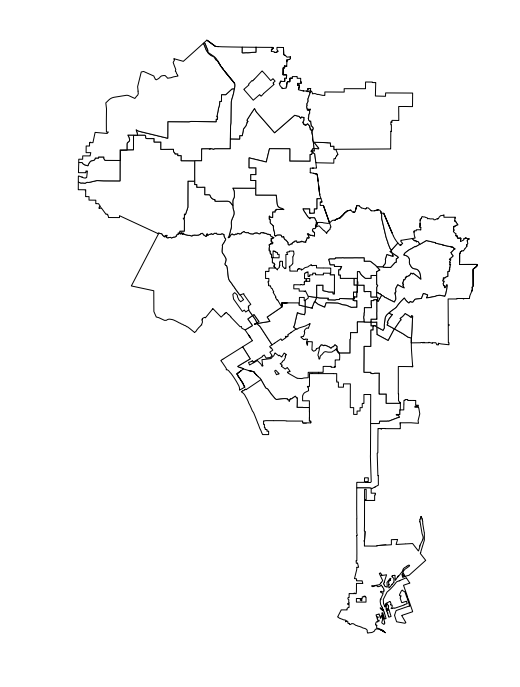

In [8]:
ax = dis_council.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off')

In [9]:
len(council), len(dis_council)

(15, 36)

## State assembly district (Not a good geo)

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/11/state_assembly_districts.zip

In [ ]:
#!unzip state_assembly_districts.zip

In [10]:
sa_dis = gpd.GeoDataFrame.from_file('state_assembly_districts.shp')

In [11]:
sa_dis = sa_dis.dropna(subset = ['geometry'])

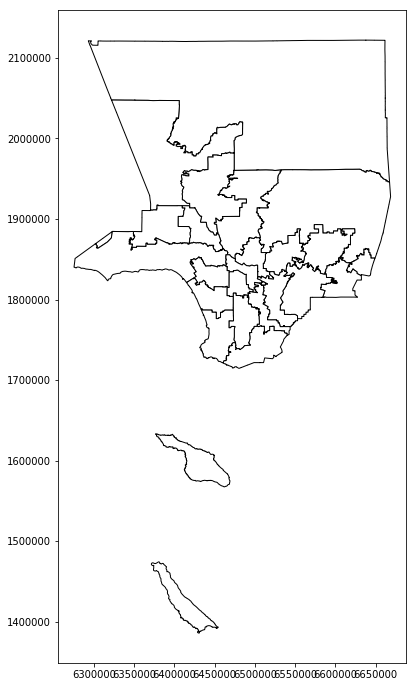

In [12]:
sa_dis.plot( color= 'w', edgecolor= 'k', figsize=(12,12))

In [13]:
dis_council = dis_council.to_crs(epsg = 4326)
sa_dis = sa_dis.to_crs(epsg = 4326)

In [14]:
council_sa = spatial_overlays(dis_council, sa_dis)

(-118.36829182150741,
 -118.14521829424955,
 33.741066100245511,
 34.319553899953959)

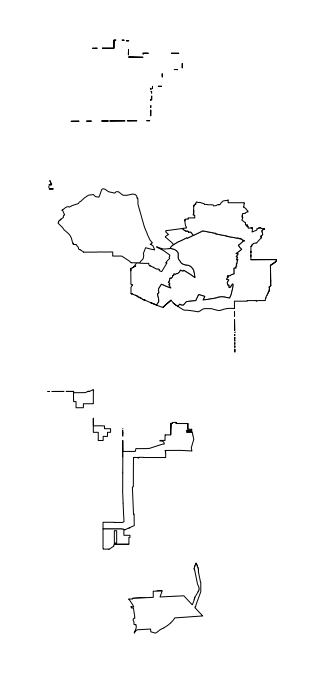

In [15]:
ax = council_sa.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off')

## Neighborhood

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2015/09/LACITY_NEIGHBORHOOD_COUNCILS.zip

In [ ]:
#!unzip LACITY_NEIGHBORHOOD_COUNCILS.zip

In [16]:
nbd = gpd.GeoDataFrame.from_file('LACITY_NEIGHBORHOOD_COUNCILS.shp')

In [17]:
council_nbd = spatial_overlays(dis_council, nbd)

Data has different projections.
Converted data to projection of first GeoPandas DatFrame


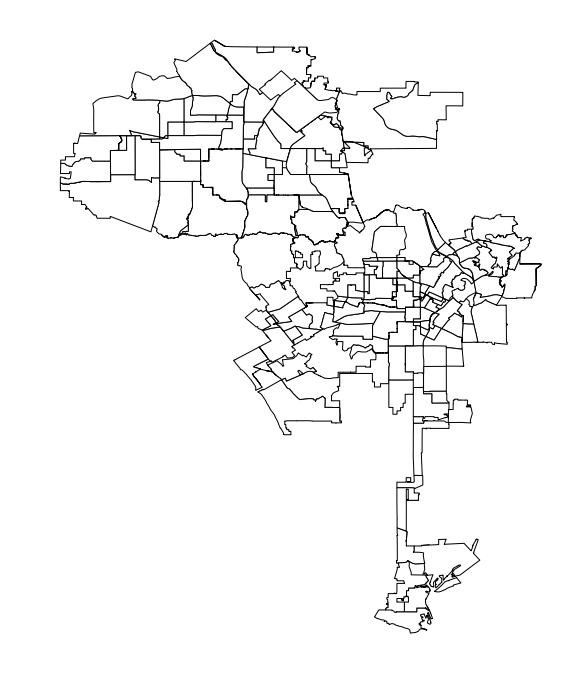

In [18]:
ax = council_nbd.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

## Election Districts

In [19]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/RRCC_PRECINCTS.zip

In [20]:
#!unzip RRCC_PRECINCTS.zip

In [21]:
pp = gpd.GeoDataFrame.from_file('RRCC_PRECINCTS.shp')

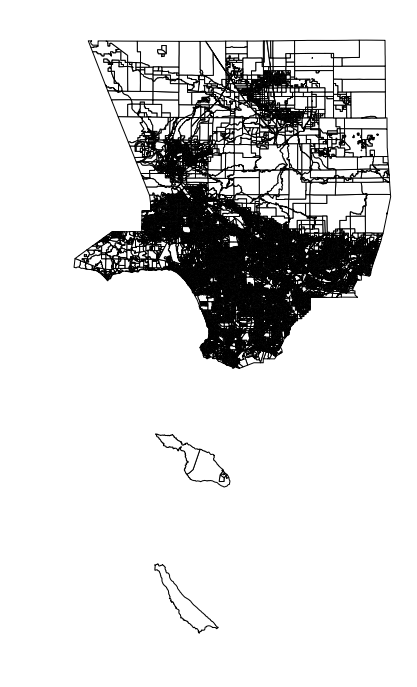

In [22]:
ax = pp.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

## Comunity Plan Areas

In [23]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/2015/09/LACITY_COMMUNITY_PLAN_AREAS.zip

In [24]:
#!unzip LACITY_COMMUNITY_PLAN_AREAS.zip

In [25]:
cpa = gpd.GeoDataFrame.from_file('LACITY_COMMUNITY_PLAN_AREAS.shp')

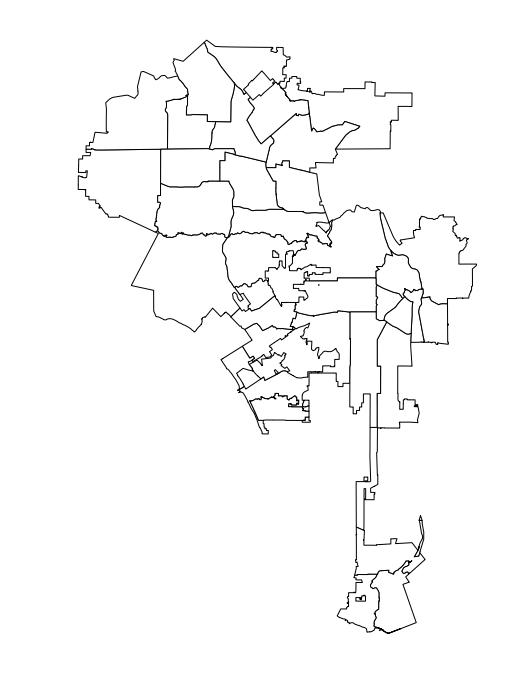

In [26]:
ax = cpa.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

In [27]:
len(council_nbd), len(cpa)

(293, 39)

In [28]:
nbd_cpa = spatial_overlays(council_nbd, cpa)

Data has different projections.
Converted data to projection of first GeoPandas DatFrame


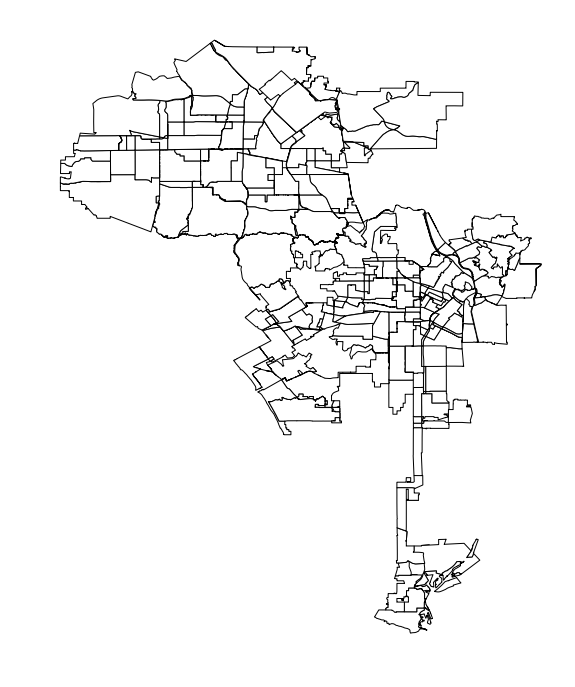

In [29]:
ax = nbd_cpa.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

In [30]:
len(council_nbd), len(nbd_cpa)

(293, 592)

## Merging above files with election districts

In [31]:
cpa_pp = spatial_overlays(nbd_cpa, pp)

Data has different projections.
Converted data to projection of first GeoPandas DatFrame


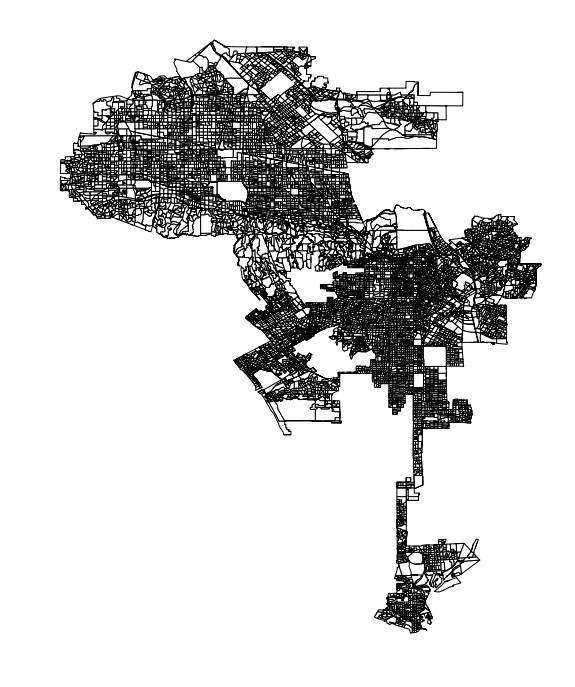

In [32]:
ax = cpa_pp.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

In [45]:
#cpa_pp.to_csv('electionDis_level_data.csv')

## Tracts

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_TRACTS_2010.zip

In [ ]:
#!unzip CENSUS_TRACTS_2010.zip

In [33]:
tract = gpd.GeoDataFrame.from_file('CENSUS_TRACTS_2010.shp')

In [34]:
nbd_tract = spatial_overlays(nbd_cpa, tract)

Data has different projections.
Converted data to projection of first GeoPandas DatFrame


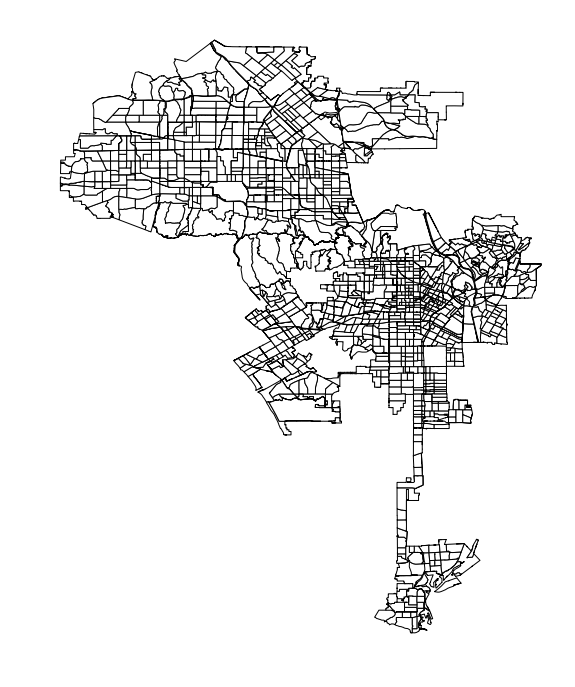

In [35]:
ax = nbd_tract.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

In [44]:
#nbd_tract.to_csv('tract_level_data.csv')

## Blocks

In [ ]:
#!curl -O http://egis3.lacounty.gov/dataportal/wp-content/uploads/ShapefilePackages/CENSUS_BLOCKS_2010.zip

In [ ]:
#!unzip CENSUS_BLOCKS_2010.zip

In [36]:
block = gpd.GeoDataFrame.from_file('CENSUS_BLOCKS_2010.shp')

In [37]:
cpa_block = spatial_overlays(nbd_cpa, block, how='intersection')

Data has different projections.
Converted data to projection of first GeoPandas DatFrame


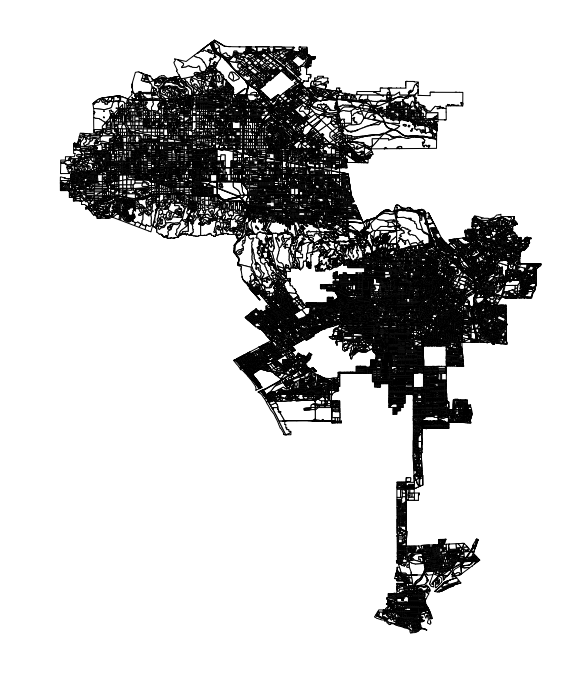

In [38]:
ax = cpa_block.plot( color= 'w', edgecolor= 'k', figsize=(12,12))
ax.axis('off');

In [43]:
#cpa_block.to_csv('block_level_data.csv')

In [41]:
#cpa_btract = spatial_overlays(nbd_tract, block, how='intersection')

In [ ]:
#dummy = gpd.GeoDataFrame.mergenbd_tract